# Introduction

## Import

In [52]:
import os

In [53]:
import numpy as np

In [54]:
import pandas as pd

In [55]:
import seaborn as sns

In [56]:
import matplotlib.pyplot as plt

In [116]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, f1_score)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import (GridSearchCV, StratifiedKFold, cross_val_score, train_test_split, RandomizedSearchCV)

## Loading

In [58]:
DATA_PATH = "/content/fifa_players.csv"
OUTPUT_PATH = "kaggle_submissions/"

S_RANDOM_STATE = 3993    # Seed for train/test data splitting
M_RANDOM_STATE = 42      # Seed for RandomForest model training

TRAIN_SIZE = 0.75

In [59]:
df = pd.read_csv(DATA_PATH)

# Utility

In [60]:
def generateSubmission(myModel, submissionFile, description):
    # Read the test data
    data = pd.read_csv(DATA_PATH)
    Id, X_test= data.Id,data.drop(columns=DROPCOLUMS)
    # Impute each test item, then predict
    X_test_imp = imp.transform(X_test)

    # Use the model to make predictions
    y_test_pred = myModel.predict(X_test_imp)

    # submission file
    my_submission = pd.DataFrame({"Id": Id, "target": y_test_pred})

    if not os.path.exists(OUTPUT_PATH):
      os.mkdir(OUTPUT_PATH)

    # you could use any filename. We choose submission here
    my_submission.to_csv(OUTPUT_PATH, index=False)

    # Submit authomatically; kaggle API authentication needed
    #!kaggle competitions submit -c heart-attack-analysis-and-prediction-21 -f {OUTPUT_PATH/submissionFile} -m '{description}'

# Features Engineering

## Missing Values

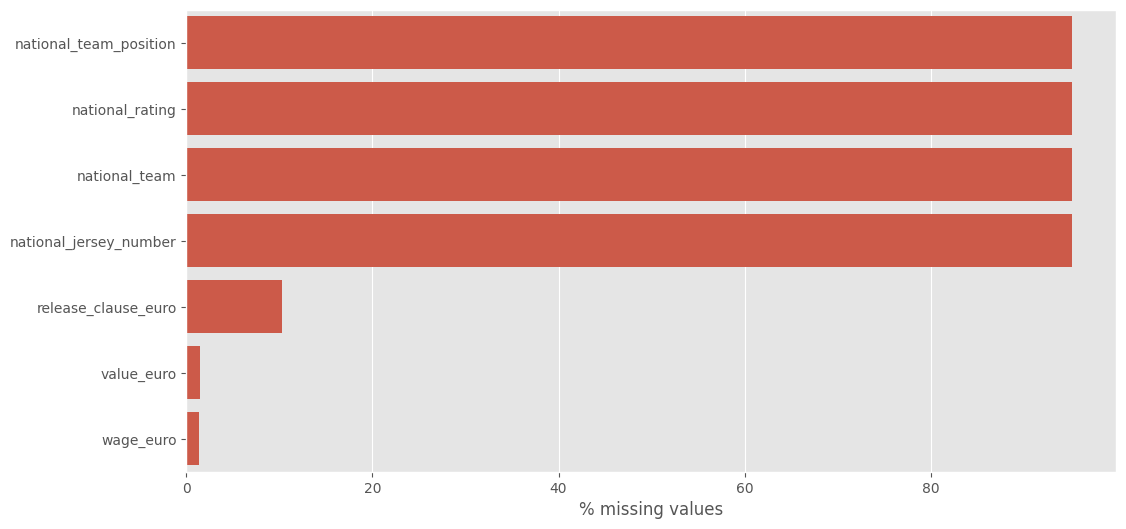

In [61]:
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
missing_pct = missing / len(df) * 100

plt.figure(figsize=(12, 6))
sns.barplot(x=missing_pct.values, y=missing_pct.index)
plt.xlabel("% missing values")
plt.ylabel("")
plt.show()

## Features

In [62]:
df_filtered = df[
    df['potential'].notna() & df['overall_rating'].notna()
    ].copy()

features=(df_filtered.columns)
print(features)

Index(['name', 'full_name', 'birth_date', 'age', 'height_cm', 'weight_kgs',
       'positions', 'nationality', 'overall_rating', 'potential', 'value_euro',
       'wage_euro', 'preferred_foot', 'international_reputation(1-5)',
       'weak_foot(1-5)', 'skill_moves(1-5)', 'body_type',
       'release_clause_euro', 'national_team', 'national_rating',
       'national_team_position', 'national_jersey_number', 'crossing',
       'finishing', 'heading_accuracy', 'short_passing', 'volleys',
       'dribbling', 'curve', 'freekick_accuracy', 'long_passing',
       'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions',
       'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots',
       'aggression', 'interceptions', 'positioning', 'vision', 'penalties',
       'composure', 'marking', 'standing_tackle', 'sliding_tackle'],
      dtype='object')


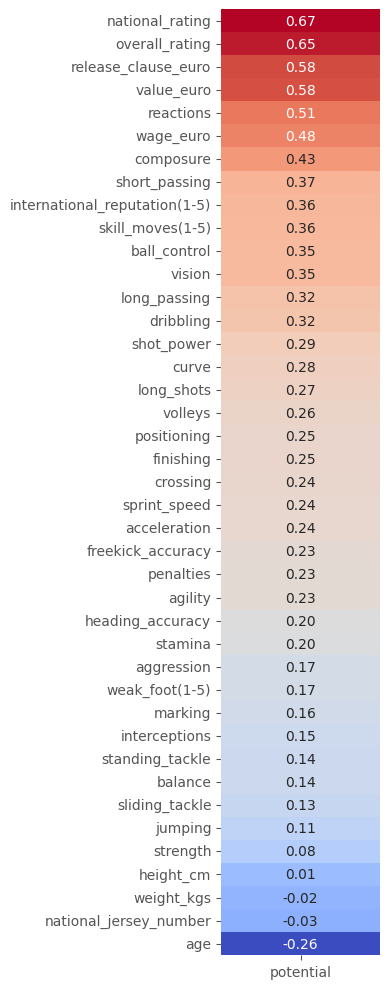

In [63]:
df_numeric = df.select_dtypes(include='number')
corr = df_numeric.corr()

features = corr['potential'].drop('potential').sort_values(ascending=False).index.tolist()

plt.figure(figsize=(4, 10))
sns.heatmap(corr.loc[features, ['potential']], annot=True, cmap='coolwarm', fmt=".2f", cbar=False)

plt.tight_layout()
plt.show()

## Aggregated Features

### 1. Growth Potential Index

Calculate growth potential based on player age and current abilities


In [64]:
df_filtered['growth_potential_index'] = np.where(

    # CONDITION 1: Very young players (age <= 23)
    df_filtered['age'] <= 23,
    # For very young: significant bonuses
    ((df_filtered['reactions'] * 0.65 + df_filtered['composure'] * 0.35) / 1.0) *
    (1 + (24 - df_filtered['age']) * 0.1 +  # Age bonus: younger = more bonus
     df_filtered['international_reputation(1-5)'] * 0.02),  # International reputation bonus

    np.where(
        # CONDITION 2: Young players (age 24-27)
        df_filtered['age'] <= 27,
        # For young: moderate age-only bonus
        ((df_filtered['reactions'] * 0.65 + df_filtered['composure'] * 0.35) / 1.0) *
        (1 + (28 - df_filtered['age']) * 0.05),  # Reduced age bonus

        # CONDITION 3: Mature players (age > 27)
        df_filtered['reactions'] * 0.65 + df_filtered['composure'] * 0.35
    )
)

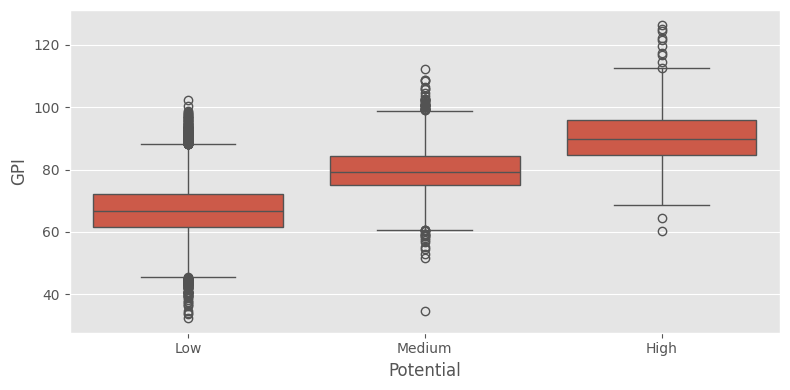

In [65]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (8, 4)

bins = [0, 76, 82, 100]
labels = ['Low', 'Medium', 'High']
df_filtered['potential_category'] = pd.cut(df_filtered['potential'], bins=bins, labels=labels)

sns.boxplot(x='potential_category', y='growth_potential_index', data=df_filtered)
plt.xlabel('Potential')
plt.ylabel('GPI')
plt.tight_layout()

### 2. Reaction Development

Normalize reaction stats based on age expectations with development multiplier


In [66]:
df_filtered['reaction_development'] = np.where(
    df_filtered['age'] <= 20, df_filtered['reactions'] / 53.6,  # Young talent benchmark
    np.where(df_filtered['age'] <= 25, df_filtered['reactions'] / 60.5,  # Developing player benchmark
    np.where(df_filtered['age'] <= 30, df_filtered['reactions'] / 65.3,  # Prime age benchmark
    df_filtered['reactions'] / 67.1))  # Veteran benchmark
) * 1.2

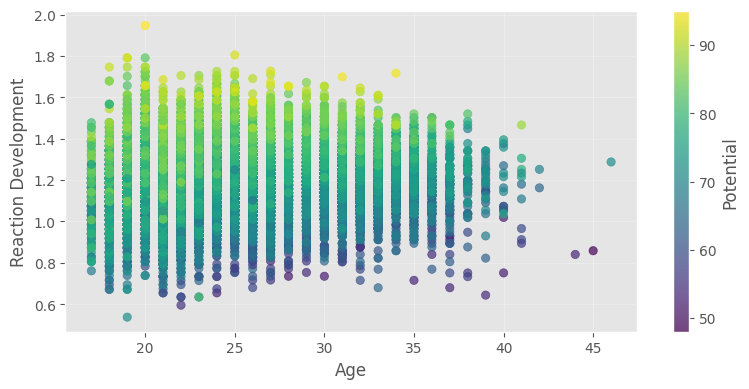

In [67]:
plt.scatter(df_filtered['age'], df_filtered['reaction_development'],
           c=df_filtered['potential'], cmap='viridis', alpha=0.7)
plt.colorbar(label='Potential')
plt.xlabel('Age')
plt.ylabel('Reaction Development')
plt.grid(True, alpha=0.3)
plt.tight_layout()

### 3. Role Quality

Extract main position and group into categories

In [68]:
df_filtered['main_position'] = df_filtered['positions'].str.split(',').str[0].str.strip()
position_groups = {
    'Attackers': ['ST', 'CF', 'LW', 'RW', 'LS', 'RS'],
    'Midfielders': ['CM', 'CAM', 'CDM', 'LM', 'RM'],
    'Defenders': ['CB', 'LB', 'RB', 'LWB', 'RWB'],
    'Goalkeepers': ['GK']
}

# Assign each player to a position group
df_filtered['position_group'] = df_filtered['main_position'].apply(
    lambda x: next((k for k, v in position_groups.items() if x in v), 'Other')
)

# Attacker quality: focus on scoring and dribbling abilities
df_filtered['attacker_quality'] = (
    df_filtered['dribbling'] * 0.25 +
    df_filtered['finishing'] * 0.25 +
    df_filtered['acceleration'] * 0.15 +
    df_filtered['positioning'] * 0.2 +
    df_filtered['reactions'] * 0.15
) / df_filtered['age']

# Midfielder quality: focus on passing and game control
df_filtered['midfielder_quality'] = (
    df_filtered['short_passing'] * 0.25 +
    df_filtered['vision'] * 0.25 +
    df_filtered['ball_control'] * 0.15 +
    df_filtered['stamina'] * 0.1 +
    df_filtered['interceptions'] * 0.15 +
    df_filtered['reactions'] * 0.1
) / df_filtered['age']

# Defender quality: focus on defensive fundamentals
df_filtered['defender_quality'] = (
    df_filtered['standing_tackle'] * 0.25 +
    df_filtered['interceptions'] * 0.25 +
    df_filtered['marking'] * 0.25 +
    df_filtered['strength'] * 0.15 +
    df_filtered['reactions'] * 0.1
) / df_filtered['age']

# Goalkeeper quality: focus on shot-stopping and composure
df_filtered['goalkeeper_quality'] = (
    df_filtered['reactions'] * 0.4 +
    df_filtered['composure'] * 0.3 +
    df_filtered['agility'] * 0.15 +
    df_filtered['jumping'] * 0.15
) / df_filtered['age']

In [69]:
df_filtered['role_quality'] = np.where(
    df_filtered['position_group'] == 'Attackers',
    df_filtered['attacker_quality'],
        np.where(
            df_filtered['position_group'] == 'Defenders',
            df_filtered['defender_quality'],
            np.where(
                df_filtered['position_group'] == 'Goalkeepers',
                df_filtered['goalkeeper_quality'],
                    df_filtered['midfielder_quality']  # default per 'Other'
        )
    )
)

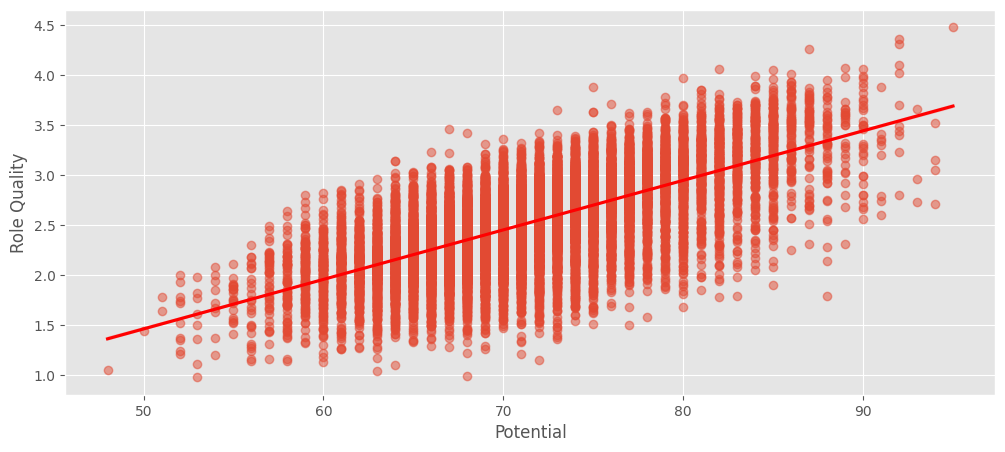

In [70]:
plt.figure(figsize=(12, 5))
sns.regplot(x='potential', y='role_quality', data=df_filtered, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.xlabel('Potential')
plt.ylabel('Role Quality')
plt.show()

### 4. Market Value



Feature considering multiple factors affecting player value

In [71]:
df_filtered['market_value'] = np.clip(
    np.sqrt(np.log1p(df_filtered['release_clause_euro'].fillna(df_filtered['value_euro'].fillna(0)))) / 15 *
    df_filtered['overall_rating'] / 150 *                                    # Current ability factor
    (1 + (28 - df_filtered['age'].clip(upper=28)) / 120) *                  # Age premium for young players
    (1 + df_filtered['international_reputation(1-5)'] * 0.05),
    0, 2  # Clip between 0 and 2 to prevent extreme values
)

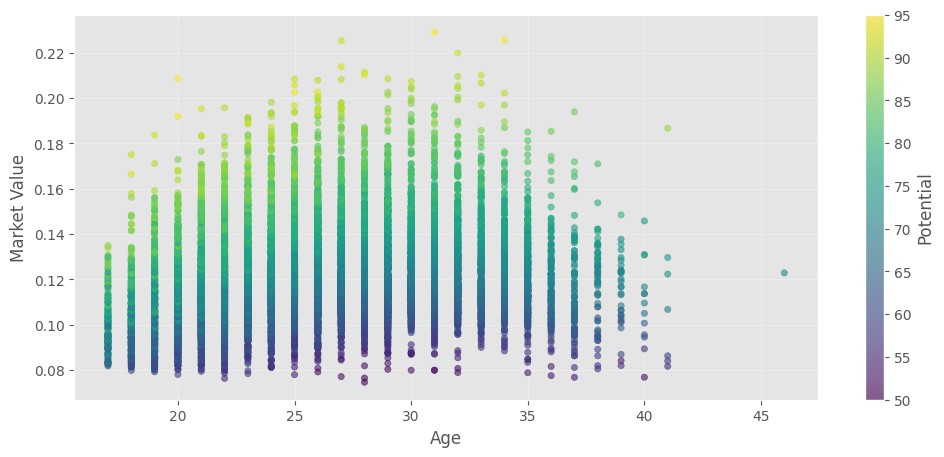

In [72]:
plt.figure(figsize=(12, 5))

df_plot = df_filtered[df_filtered['market_value'] != 0]

scatter = plt.scatter(df_plot['age'], df_plot['market_value'],
                      c=df_plot['potential'], cmap='viridis', alpha=0.6, s=20)

plt.xlabel('Age')
plt.ylabel('Market Value')
plt.grid(True, alpha=0.3)
plt.colorbar(scatter, label='Potential')

plt.show()

In [73]:
median_value_by_overall = df_filtered.groupby('overall_rating')['value_euro'].median()

# Compare each player's value to others with similar overall rating
df_filtered['relative_market_value'] = df_filtered.apply(
    lambda x: x['value_euro'] / median_value_by_overall.get(x['overall_rating'], 1)
    if x['overall_rating'] in median_value_by_overall else 1, axis=1
)

### 5. Athletic Potential Index

Measure of physical and technical attributes that translate to game impact

In [74]:
df_filtered['athletic_potential_index'] = (
    df_filtered['acceleration'] * 0.15 +
    df_filtered['sprint_speed'] * 0.15 +
    df_filtered['agility'] * 0.1 +
    df_filtered['shot_power'] * 0.2 +
    df_filtered['long_shots'] * 0.15 +
    df_filtered['stamina'] * 0.15 +
    df_filtered['dribbling'] * 0.1
)

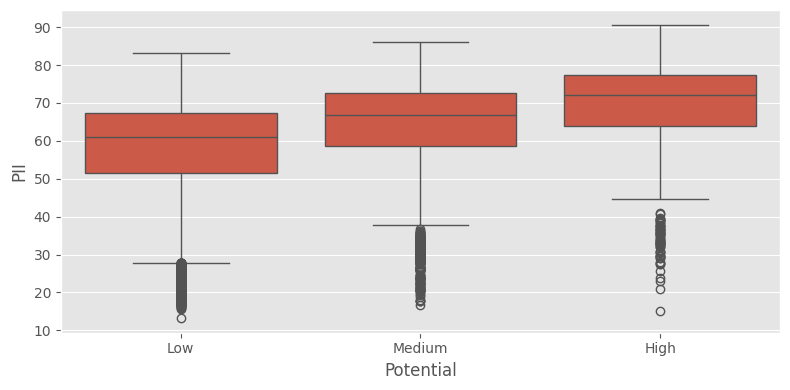

In [75]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (8, 4)

bins = [0, 76, 82, 100]
labels = ['Low', 'Medium', 'High']
df_filtered['potential_category'] = pd.cut(df_filtered['potential'], bins=bins, labels=labels)

sns.boxplot(x='potential_category', y='athletic_potential_index', data=df_filtered)
plt.xlabel('Potential')
plt.ylabel('PII')
plt.tight_layout()

### 6. Skill to Price

Technical quality to price ratio

In [76]:
# Calculate overall technical skill level
df_filtered['skill_level'] = (
    0.25 * df_filtered['ball_control'] +
    0.25 * df_filtered['composure'] +
    0.15 * df_filtered['vision'] +
    0.15 * df_filtered['short_passing'] +
    0.10 * df_filtered['agility'] +
    0.10 * df_filtered['acceleration']
)

df_filtered['skill_to_price'] = (
    df_filtered['skill_level'] / (df_filtered['value_euro'] / 1_000_000) # Value in Millions
)

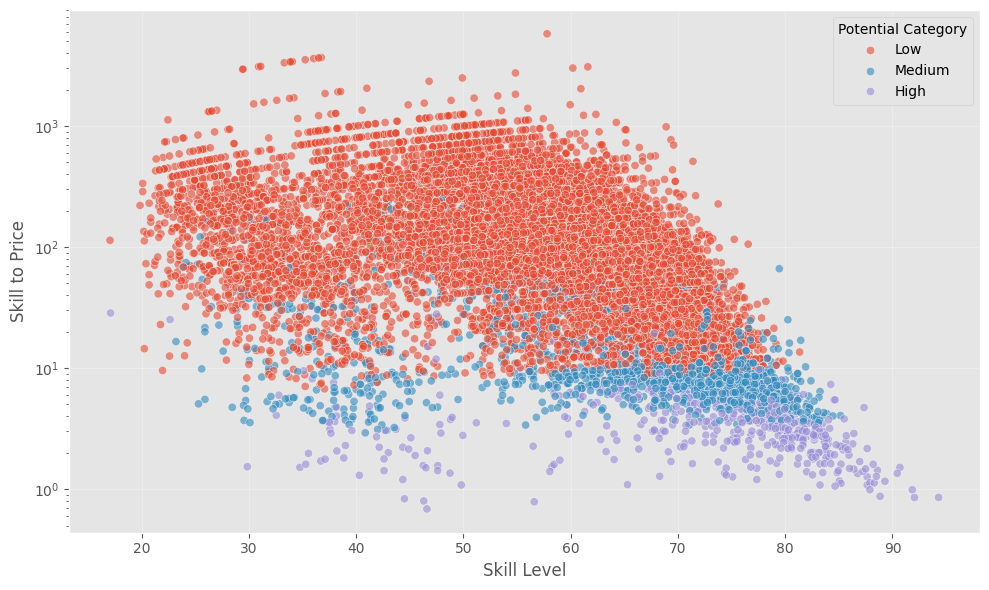

In [77]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='skill_level', y='skill_to_price', hue='potential_category', data=df_filtered, alpha=0.6)
plt.xlabel('Skill Level')
plt.yscale('log')
plt.ylabel('Skill to Price')
plt.grid(True, alpha=0.3)
plt.legend(title='Potential Category')
plt.tight_layout()
plt.show()

### 7. Overall Rating Aged

Current rating adjusted for age

In [78]:
df_filtered['overall_rating_aged'] = np.where(
    df_filtered['age'] <= 25,
    df_filtered['overall_rating'] * (0.9 + (26 - df_filtered['age']) * 0.08),# Youth bonus
    df_filtered['overall_rating'] * 0.9 # Standard rating for older players
)

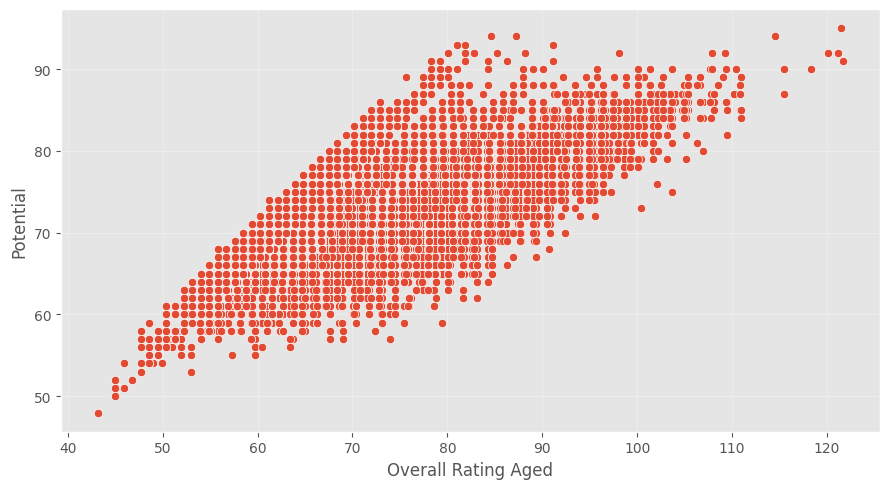

In [79]:
plt.figure(figsize=(9, 5))
sns.scatterplot(data=df_filtered, x='overall_rating_aged', y='potential')
plt.xlabel('Overall Rating Aged')
plt.ylabel('Potential')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Summary

In [80]:
FEATURES = [

    'growth_potential_index',
    'reaction_development',
    'role_quality',
    'market_value',
    'relative_market_value',
    'athletic_potential_index',
    'skill_to_price',
    'overall_rating_aged',

    'potential'

    ]

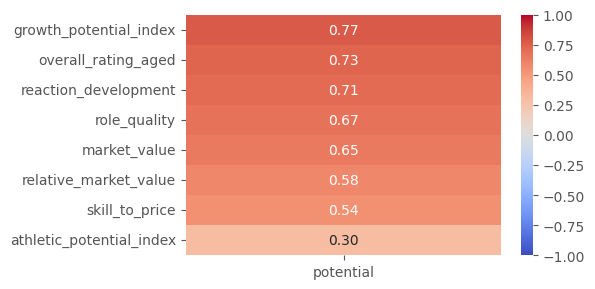

In [81]:
corr_with_potential = df_filtered[FEATURES].corr()[['potential']].abs().drop('potential').sort_values(by='potential', ascending=False)

plt.figure(figsize=(6, 3))
sns.heatmap(corr_with_potential, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.tight_layout()
plt.show()

FEATURES.remove('potential')

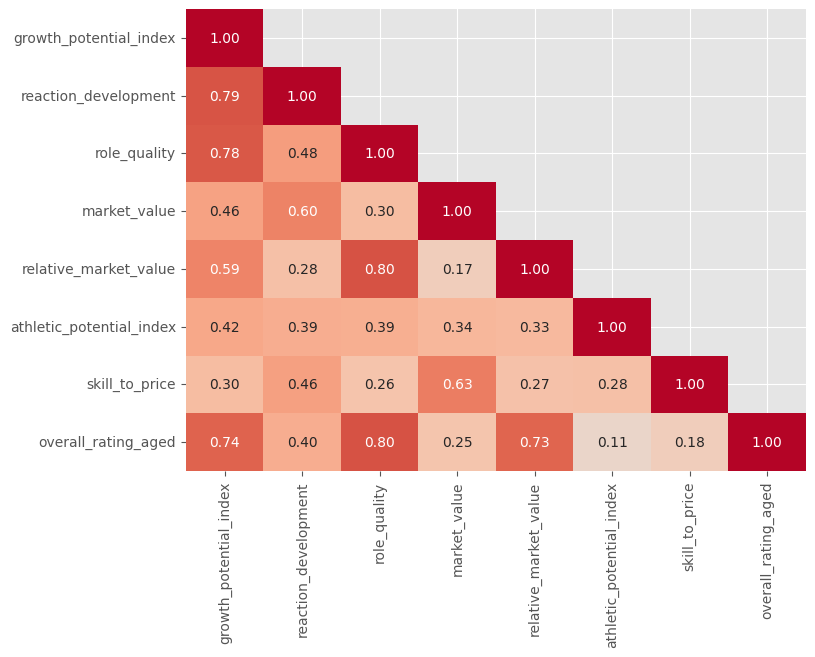

In [82]:
corr_with_potential = df_filtered[FEATURES].corr().abs()
mask = np.triu(np.ones_like(corr_with_potential, dtype=bool), k=1)

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_with_potential,
    mask=mask,
    annot=True,
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    fmt='.2f',
    cbar=False,
)
plt.show()

## Target

In [83]:
bins = [0, 76, 82, 100]
labels = [0, 1, 2]       # Low, Medium, High
df_filtered['target'] = pd.cut(df_filtered['potential'], bins=bins, labels=labels)


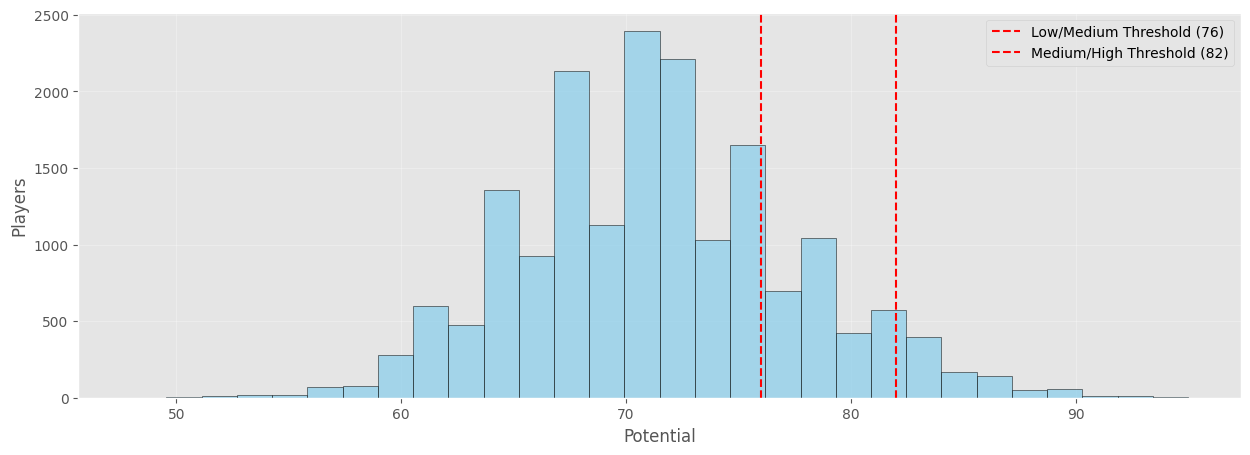

In [84]:
plt.figure(figsize=(15, 5))

plt.hist(df_filtered['potential'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(76, color='red', linestyle='--', label='Low/Medium Threshold (76)')
plt.axvline(82, color='red', linestyle='--', label='Medium/High Threshold (82)')
plt.xlabel('Potential')
plt.ylabel('Players')
plt.legend()
plt.grid(True, alpha=0.3)

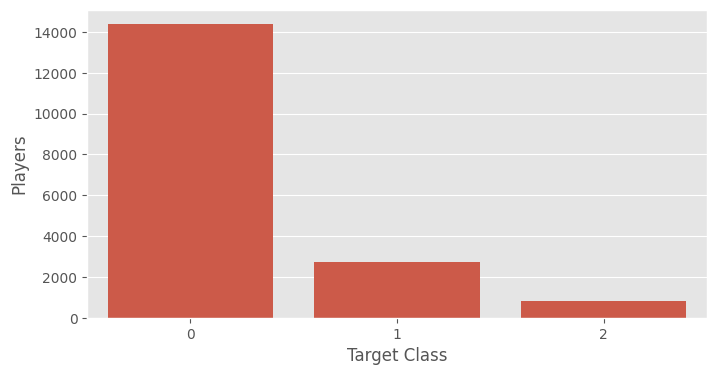

In [85]:
df_filtered['target_label'] = df_filtered['target']

sns.countplot(x='target_label', data=df_filtered)
plt.xlabel('Target Class')
plt.ylabel('Players')
plt.show()

# Data Processing

In [86]:
X = df_filtered[FEATURES].copy()
y = df_filtered['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=TRAIN_SIZE, random_state=S_RANDOM_STATE, stratify=y
)

In [87]:
BINARY_COLS = []
print(f"Number of binary cols: {len(BINARY_COLS)}")

NUMERICAL_COLS = [col for col in X.columns if X[col].dtype in ['float64', 'int64']]
print(f"Number of numerical cols: {len(NUMERICAL_COLS)}")

CATEGORICAL_COLS = [col for col in X.columns if col not in NUMERICAL_COLS]
print(f"Number of categorical cols: {len(CATEGORICAL_COLS)}")

Number of binary cols: 0
Number of numerical cols: 8
Number of categorical cols: 0


In [88]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

categorical_transformer = SimpleImputer(strategy='most_frequent')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, NUMERICAL_COLS),
        ('cat', categorical_transformer, CATEGORICAL_COLS),
    ],
    verbose=False,
)

In [89]:
# Preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Model

In [124]:
models = {
    'Random Forest': RandomForestClassifier(
        random_state=M_RANDOM_STATE,
    ),

    'Support Vector Machine': SVC(
        random_state=M_RANDOM_STATE,
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        random_state=M_RANDOM_STATE,
    ),
}

In [125]:
results = []

for name, model in models.items():
    model.fit(X_train_processed, y_train)
    train_score = f1_score(y_train, model.predict(X_train_processed), average='macro')

    results.append({
        'Model': name,
        'Train_F1': train_score
    })

results_df = pd.DataFrame(results).sort_values('Train_F1', ascending=False)
print(results_df.round(4))

                    Model  Train_F1
0           Random Forest    1.0000
2       Gradient Boosting    0.9318
1  Support Vector Machine    0.8736


## Validation & Tuning

In [ ]:
# Parameter grid
param_grid = {
    'n_estimators': [200, 400],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 15, 20],
    'min_samples_leaf': [3, 5, 8],
    'max_features': [0.5, 0.7, 'sqrt'],
    'class_weight': ['balanced', {0: 1.0, 1: 3, 2: 7.5}]
}

# Grid search
rf_grid = RandomizedSearchCV(
    RandomForestClassifier(random_state=M_RANDOM_STATE, n_jobs=-1, oob_score=True, bootstrap=True),
    param_grid,
    n_iter=30,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=M_RANDOM_STATE),
    scoring='f1_macro',
    random_state=M_RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train_processed, y_train)

In [127]:
# Extract all CV results
cv_results = []
fitted_models = {}

for i in range(len(rf_grid.cv_results_['params'])):
    params = rf_grid.cv_results_['params'][i]
    model_id = f'Grid_{i+1:02d}'

    temp_model = RandomForestClassifier(random_state=M_RANDOM_STATE, n_jobs=-1, oob_score=True, bootstrap=True,
                                        **params)
    temp_model.fit(X_train_processed, y_train)
    train_acc = temp_model.score(X_train_processed, y_train)

    cv_results.append({
        'Model_ID': model_id,
        'CV_F1': rf_grid.cv_results_['mean_test_score'][i],
        'Train_Acc': train_acc,
        'Params': params
    })
    fitted_models[model_id] = temp_model #Save fitted models

# Sort by CV F1-Score
df_models = pd.DataFrame(cv_results).sort_values('CV_F1', ascending=False)

print("TOP 10 MODELS (CV-based):\n")
for i, row in df_models.head(10).iterrows():
    model_id = row['Model_ID']
    model = fitted_models[model_id]

    # Get top 3 features
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    top3_features = [f"{FEATURES[indices[j]]}({importances[indices[j]]:.3f})" for j in range(3)]

    print(f"{model_id}: CV_F1={row['CV_F1']:.4f}, Train_Accuracy={row['Train_Acc']:.3f}")
    print(f"   {top3_features}")
    print()

TOP 10 MODELS (CV-based):

Grid_30: CV_F1=0.8913, Train_Accuracy=0.993
   ['overall_rating_aged(0.226)', 'growth_potential_index(0.197)', 'skill_to_price(0.174)']

Grid_09: CV_F1=0.8892, Train_Accuracy=0.994
   ['growth_potential_index(0.230)', 'overall_rating_aged(0.224)', 'skill_to_price(0.186)']

Grid_08: CV_F1=0.8869, Train_Accuracy=0.991
   ['overall_rating_aged(0.254)', 'growth_potential_index(0.194)', 'skill_to_price(0.173)']

Grid_21: CV_F1=0.8864, Train_Accuracy=0.993
   ['growth_potential_index(0.231)', 'overall_rating_aged(0.225)', 'skill_to_price(0.184)']

Grid_23: CV_F1=0.8860, Train_Accuracy=0.991
   ['overall_rating_aged(0.252)', 'growth_potential_index(0.225)', 'skill_to_price(0.190)']

Grid_01: CV_F1=0.8851, Train_Accuracy=0.982
   ['overall_rating_aged(0.235)', 'growth_potential_index(0.197)', 'skill_to_price(0.180)']

Grid_15: CV_F1=0.8845, Train_Accuracy=0.989
   ['overall_rating_aged(0.200)', 'skill_to_price(0.164)', 'growth_potential_index(0.152)']

Grid_06: CV_F1

## Best Model

In [96]:
candidates = df_models[df_models['Train_Acc'] < 0.99]  # No overfitting->1

# Select the best by CV_F1-Score
best_model_info = candidates.iloc[0]
best_model_id = best_model_info['Model_ID']

model = fitted_models[best_model_id]

In [97]:
print(f"BEST MODEL: {best_model_id}\n")
print(f"   CV F1-Score: {best_model_info['CV_F1']:.4f}")
print(f"   Train Accuracy: {best_model_info['Train_Acc']:.4f}\n")

for param, value in best_model_info['Params'].items():
    print(f"   {param}: {value}")

BEST MODEL: Grid_01

   CV F1-Score: 0.8851
   Train Accuracy: 0.9818

   n_estimators: 400
   min_samples_leaf: 5
   max_features: 0.5
   max_depth: 20
   criterion: entropy
   class_weight: {0: 1.0, 1: 3, 2: 7.5}


## Test

In [128]:
# Predictions
y_train_pred = model.predict(X_train_processed)
y_test_pred = model.predict(X_test_processed)

# Metrics
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
train_f1 = f1_score(y_train, y_train_pred, average='macro')
test_f1 = f1_score(y_test, y_test_pred, average='macro')
overfitting_gap = train_acc - test_acc

print(f"   Train Accuracy: {train_acc:.4f}")
print(f"   Test Accuracy:  {test_acc:.4f}")
print(f"   OOB Score:      {model.oob_score_:.4f}\n")

print(f"   Train F1-macro: {train_f1:.4f}")
print(f"   Test F1-macro:  {test_f1:.4f}\n")
print(f"   Overfitting Gap: {overfitting_gap:.4f}")

   Train Accuracy: 0.9854
   Test Accuracy:  0.9490
   OOB Score:      0.9499

   Train F1-macro: 0.9744
   Test F1-macro:  0.8935

   Overfitting Gap: 0.0364


In [99]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

Confusion Matrix:
[[3508   87    0]
 [  70  579   35]
 [   0   21  189]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3595
           1       0.84      0.85      0.84       684
           2       0.84      0.90      0.87       210

    accuracy                           0.95      4489
   macro avg       0.89      0.91      0.90      4489
weighted avg       0.95      0.95      0.95      4489



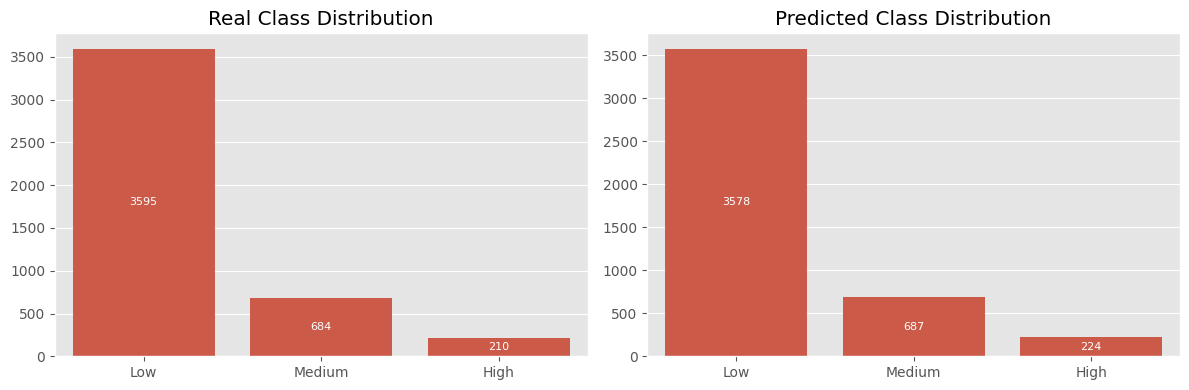

In [100]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.countplot(x=y_test, ax=ax[0])
ax[0].set_title("Real Class Distribution")
ax[0].set_xticks([0, 1, 2])
ax[0].set_xticklabels(['Low', 'Medium', 'High'])
ax[0].set_xlabel("")
ax[0].set_ylabel("")

for p in ax[0].patches:
    height = p.get_height()
    ax[0].text(p.get_x() + p.get_width()/2, height/2, int(height),
               ha='center', va='center', color='white', fontsize=8)


sns.countplot(x=y_test_pred, ax=ax[1])
ax[1].set_title("Predicted Class Distribution")
ax[1].set_xticks([0, 1, 2])
ax[1].set_xticklabels(['Low', 'Medium', 'High'])
ax[1].set_xlabel("")
ax[1].set_ylabel("")


for p in ax[1].patches:
    height = p.get_height()
    ax[1].text(p.get_x() + p.get_width()/2, height/2, int(height),
               ha='center', va='center', color='white', fontsize=8)

plt.tight_layout()
plt.show()

In [101]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

feature_importance_df = pd.DataFrame({
    'Feature': [FEATURES[i] for i in indices],
    'Importance': [importances[i] for i in indices]
})

print("\nFeature Importance:")
print(feature_importance_df.head(20))



Feature Importance:
                    Feature  Importance
0       overall_rating_aged    0.234986
1    growth_potential_index    0.196566
2            skill_to_price    0.179780
3              market_value    0.141091
4     relative_market_value    0.108587
5      reaction_development    0.073747
6              role_quality    0.041994
7  athletic_potential_index    0.023248


# Submission

In [102]:
my_submission = pd.DataFrame({
    "full_name": df_filtered.loc[y_test.index, "full_name"],
    "target": y_test_pred,
    "potential" : y_test
})
my_submission.to_csv(OUTPUT_PATH + "submission.csv", index=False)

In [103]:
error_mask = y_test != y_test_pred
error_indices = y_test.index[error_mask]

df_errors = df_filtered.loc[error_indices].copy()
df_errors["true_target"] = y_test[error_mask]
df_errors["predicted_target"] = y_test_pred[error_mask]

df_errors.to_csv(OUTPUT_PATH + "submission_errors.csv", index=False)